In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
grid_size = 5
initial_state = np.array([0,0])
loc_a = np.array([0,1])
loc_a_ = np.array([4,1])
rew_a = 10
loc_b = np.array([0,3])
loc_b_ = np.array([2,3])
rew_b = 5

In [3]:
def next_state(state, action):
    if state[0] == loc_a[0] and state[1] == loc_a[1]:
                    return loc_a_, rew_a
    elif state[0] == loc_b[0] and state[1] == loc_b[1]:
                    return loc_b_, rew_b
    else:
        if action == 'N':
            if state[0] == 0:
                return state, -1
            else:
                state = state + np.array([-1,0])
                return state, 0
        if action == 'S':
            if state[0] == grid_size - 1:
                return state, -1
            else:
                state = state + np.array([1,0])
                return state, 0
        if action == 'W':
            if state[1] == 0:
                return state, -1
            else:
                state = state + np.array([0,-1])
                return state, 0
        if action == 'E':
            if state[1] == grid_size -1 :
                return state, -1
            else:
                state = state + np.array([0,1])
                return state, 0

In [4]:
def compute_state_val_function(max_iterations, eps, policy, state_value=None):
    if state_value is None:
        val_function = np.zeros((max_iterations+1, grid_size, grid_size))
    else: 
        val_function_help = state_value[-1,:,:]
        val_function = np.zeros((max_iterations+1, grid_size, grid_size))
        val_function[0,:,:] = val_function_help

    change = np.zeros(max_iterations+1)
    actions = ['N','S','W','E']
    iteration = 0
    gamma = 0.9
    change[0] = 10
    while iteration < max_iterations:
        for i in range(grid_size):
            for j in range(grid_size):
                value = 0 
                for action_idx, action in enumerate(actions):
                    astate, arew = next_state(np.array([i,j]), action)
                    value += policy[i,j,action_idx] * (arew + gamma * val_function[iteration,astate[0],astate[1]])
                val_function[iteration+1,i,j] = value
        change[iteration] = abs(np.sum(val_function[iteration]-val_function[iteration+1]))
        if change[iteration] < eps: 
            break
        iteration += 1
    return val_function[:iteration+1,:,:], change[:iteration+1]

In [5]:
def compute_action_val_function(max_iterations, eps, policy):
    
    actions = ['N','S','W','E']
    val_function = np.zeros((max_iterations, grid_size,grid_size, len(actions)))
    change = np.zeros(max_iterations)
    iteration = 0
    gamma = 0.9
    change[0] = 10
    while iteration <= max_iterations:
        for i in range(grid_size):
            for j in range(grid_size):
                for action_index, action in enumerate(actions):
                    astate, arew = next_state(np.array([i,j]),action)
                    value = arew + gamma * policy[i,j,action_index] * np.sum(val_function[iteration,astate[0],astate[1],:])
                    val_function[iteration+1,i,j,action_index] = value
        change[iteration] = abs(np.sum(val_function[iteration]-val_function[iteration+1]))
        if change[iteration] < eps: 
            break
        iteration += 1
    return val_function[:iteration,:,:,:], change[:iteration]

So far, we just copied the algorithms we implemented for Sheet02. Now we want to perform Policy Improvement: 
The initial policy is defined by doing random steps, i.e probability 0.25 for each of the four possible steps. 

We now start with exercise a). The function policy_improvement_state_value() implements policy improvement using the state value function. 



In [6]:
def policy_improvement_state_value(max_policy_improvement_iterations, max_iterations_state, epsilon_state): 
    num_actions = 4
    grid_size = 5
    gamma = 0.9
    actions = ["N", "S", "W", "E"]
    policy = 1/num_actions * np.ones((grid_size, grid_size, num_actions))
    
    state_value, _ = compute_state_val_function(max_iterations_state, epsilon_state, policy)
    state_value = state_value[-1, :, :]    
    for i in range(max_policy_improvement_iterations): 
        current_policy = np.zeros((grid_size, grid_size, num_actions))

        #Choose new policy as argmax 
        for j in range(grid_size): 
            for k in range(grid_size): 
                values_of_strange_q = np.zeros(num_actions)
                for l in range(num_actions): 
                    new_state, reward_a = next_state(np.array([j,k]), actions[l])
                    values_of_strange_q[l] = reward_a + gamma * state_value[new_state[0], new_state[1]]

                best_actions = np.where(values_of_strange_q == np.max(values_of_strange_q))[0] # i.e. argmax but cooler
                current_policy[j,k, best_actions] = 1/len(best_actions)
        
        current_state_value, _ = compute_state_val_function(max_iterations_state, epsilon_state, current_policy)
        current_state_value = current_state_value[-1, :, :]

        if np.all(current_policy == policy): 
            print("terminated because of no policy improvement")
            return current_policy, current_state_value

        policy = current_policy
        state_value = current_state_value

    print("terminated because of max iterations")
    return current_policy, current_state_value        

In [7]:
max_policy_improvement_iterations = 30
max_iterations_state = 100000
max_iterations_action = 100000
epsilon_state = 1e-14
epsilon_action = 1e-14
current_policy, current_state_value_end = policy_improvement_state_value(max_policy_improvement_iterations, max_iterations_state, epsilon_state)

terminated because of no policy improvement


We now visualize the optimal policy and the finale state value function for each gridcell. 

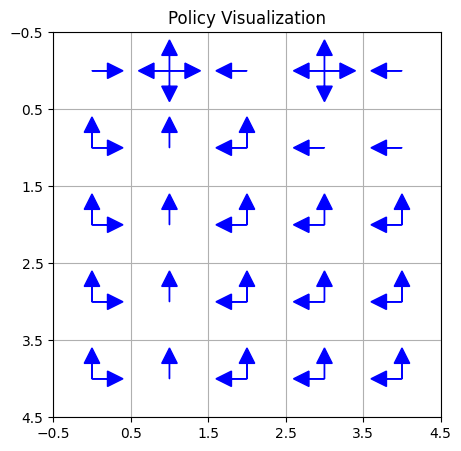

In [8]:
def visualize_policy(policy):
    n_rows, n_cols, n_dirs = policy.shape

    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True)
    
    # Arrow parameters
    arrow_params = {
        "head_width": 0.2,
        "head_length": 0.2,
        "length_includes_head": True,
        "color": "blue",
    }
    
    for i in range(n_rows):
        for j in range(n_cols):
            # Check each direction
            if policy[i, j, 0] > 0:  # North
                ax.arrow(j, i, 0, -0.4, **arrow_params)
            if policy[i, j, 1] > 0:  # South
                ax.arrow(j, i, 0, 0.4, **arrow_params)
            if policy[i, j, 2] > 0:  # West
                ax.arrow(j, i, -0.4, 0, **arrow_params)
            if policy[i, j, 3] > 0:  # East
                ax.arrow(j, i, 0.4, 0, **arrow_params)
    
    # Reverse the y-axis to align with matrix indexing
    ax.invert_yaxis()
    plt.title("Policy Visualization")
    plt.show()

visualize_policy(current_policy)


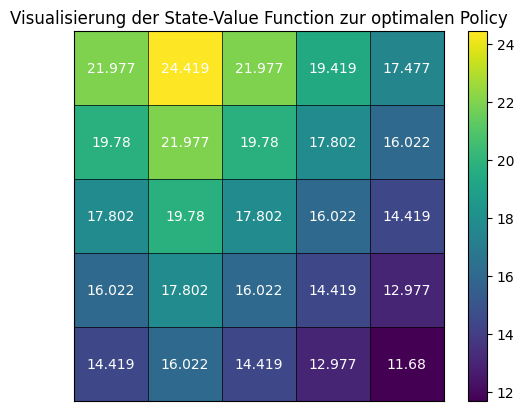

In [9]:
def visualize_state_value_function(state_values): 
    matrix = np.round(state_values, 3)
    fig, ax = plt.subplots()

    cax = ax.imshow(matrix, cmap='viridis', origin='upper')

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, matrix[i, j], ha='center', va='center', color='white')

    plt.colorbar(cax)
    plt.grid(visible=True, color='black', linestyle='-', linewidth=0.5)

    ax.set_xticks(np.arange(-0.5, 5, 1))
    ax.set_yticks(np.arange(-0.5, 5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f"Visualisierung der State-Value Function zur optimalen Policy")
    ax.tick_params(length=0)  # Entfernt die kleinen Ticks auf den Achsen

    plt.grid(True)
    plt.show()

visualize_state_value_function(current_state_value_end)

We now start with b), i.e implementing the Value iteration algorithm. To do so, we changed the max_iterations argument of the state_value computation to 1. 

In [10]:
def policy_improvement_value_iteration(max_policy_improvement_iterations): 
    num_actions = 4
    grid_size = 5
    gamma = 0.9
    actions = ["N", "S", "W", "E"]
    policy = 1/num_actions * np.ones((grid_size, grid_size, num_actions))

    #now max_iterations = 1 so the compuation stops after one computational step
    state_value, _ = compute_state_val_function(1, 1, policy)
    state_value_last = state_value[-1, :, :]

    visualize_state_value_function(state_value_last)
    
    for i in range(max_policy_improvement_iterations): 
        current_policy = np.zeros((grid_size, grid_size, num_actions))

        #Choose new policy as argmax 
        for j in range(grid_size): 
            for k in range(grid_size): 
                values_of_strange_q = np.zeros(num_actions)
                for l in range(num_actions): 
                    new_state, reward_a = next_state(np.array([j,k]), actions[l])
                    values_of_strange_q[l] = reward_a + gamma * state_value_last[new_state[0], new_state[1]]
                best_actions = np.where(values_of_strange_q == np.max(values_of_strange_q))[0] # i.e. argmax but cooler
                current_policy[j,k, best_actions] = 1/len(best_actions)
        
        current_state_value, _ = compute_state_val_function(1, 1, current_policy, state_value)
        current_state_value_last = current_state_value[-1, :, :]

        visualize_state_value_function(current_state_value_last)
        
        if np.all(current_policy == policy): 
            print("terminated because of no policy improvement")
            return current_policy, current_state_value_last

        policy = current_policy
        state_value = current_state_value
        state_value_last = current_state_value_last

        visualize_policy(policy)

    print("terminated because of max iterations")
    return current_policy, current_state_value_last     

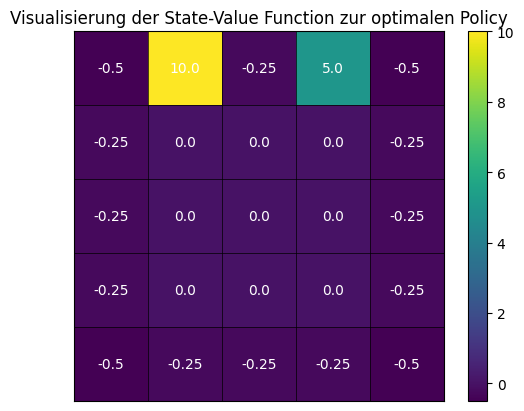

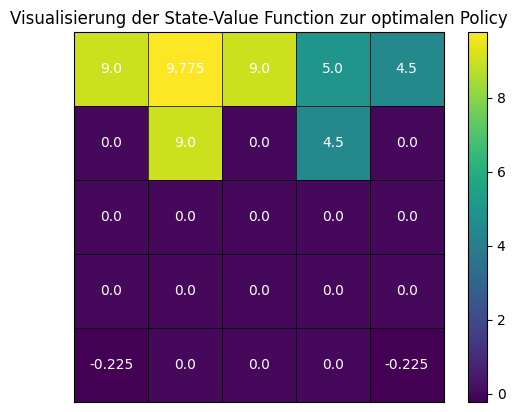

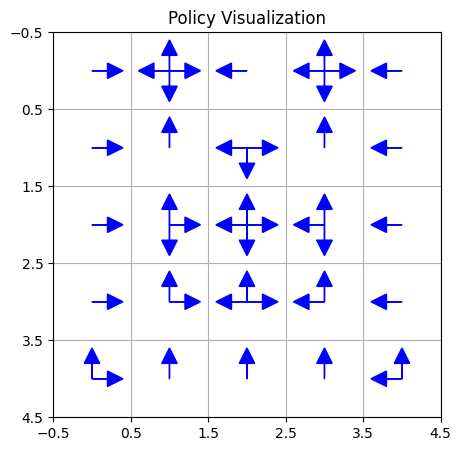

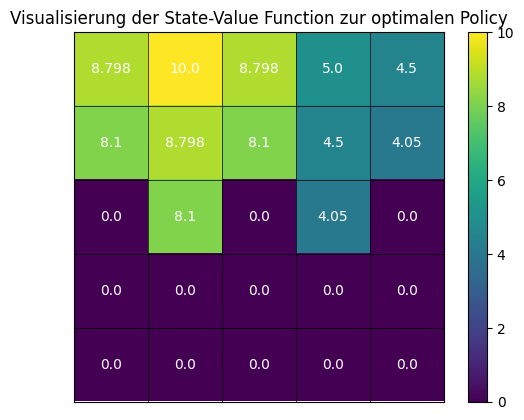

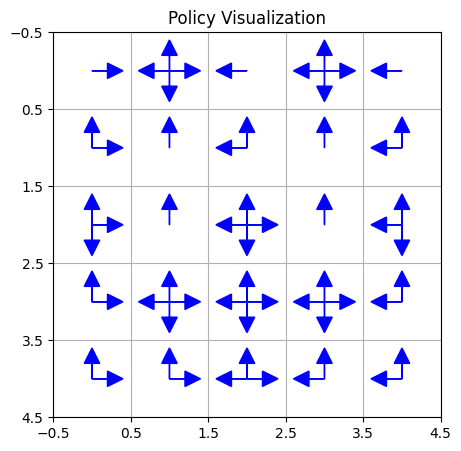

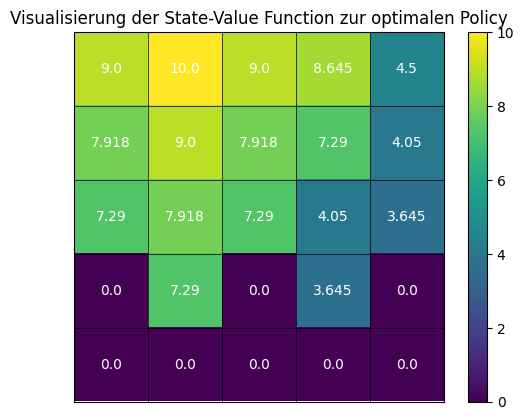

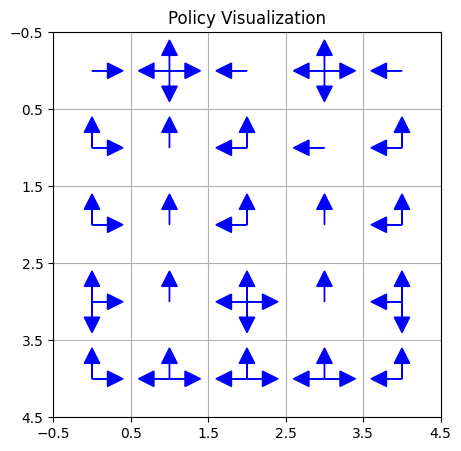

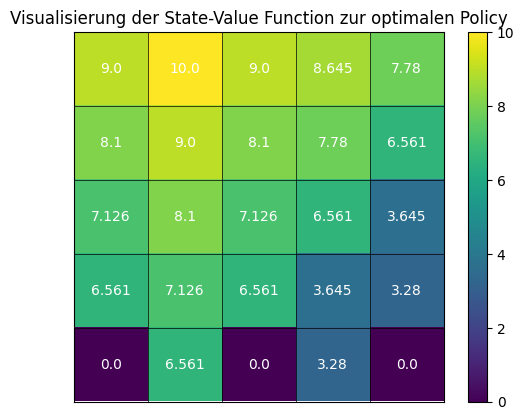

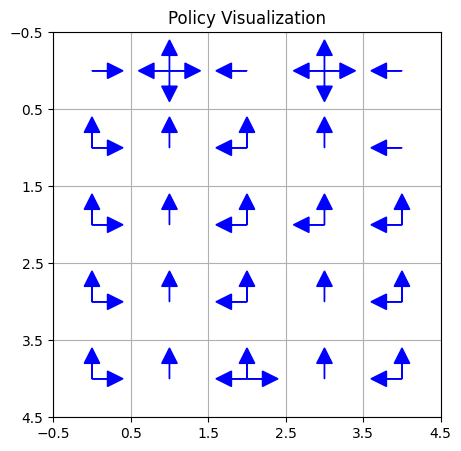

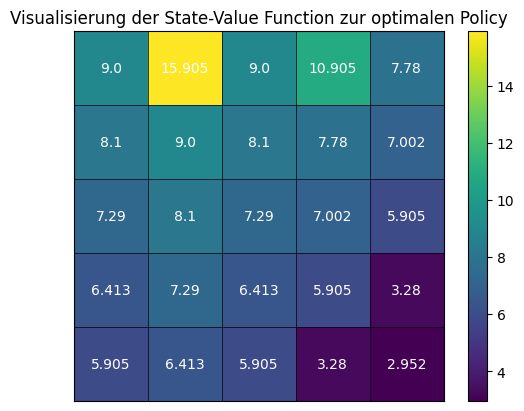

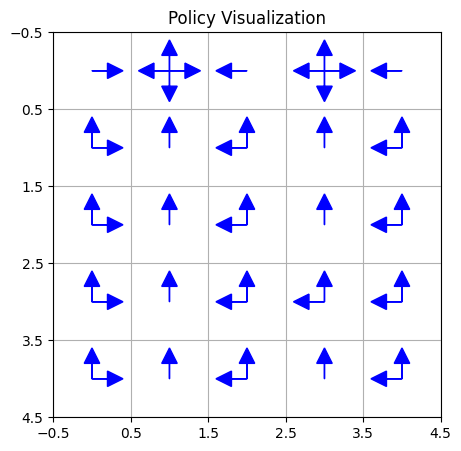

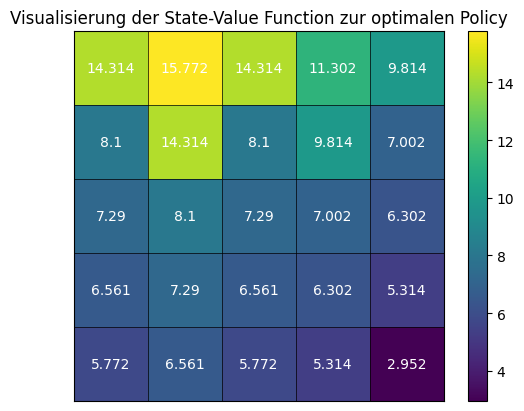

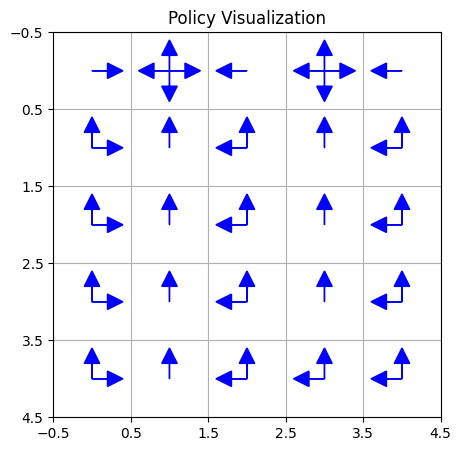

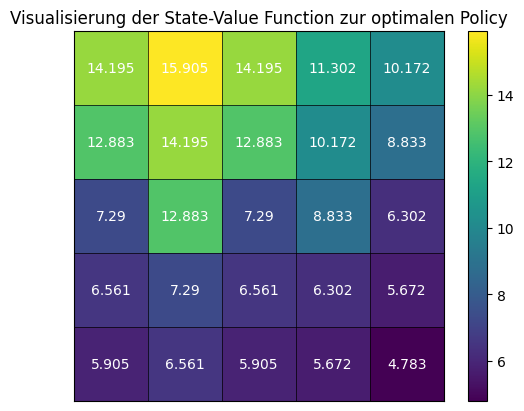

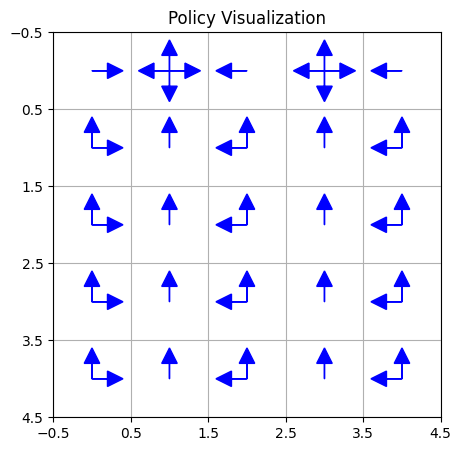

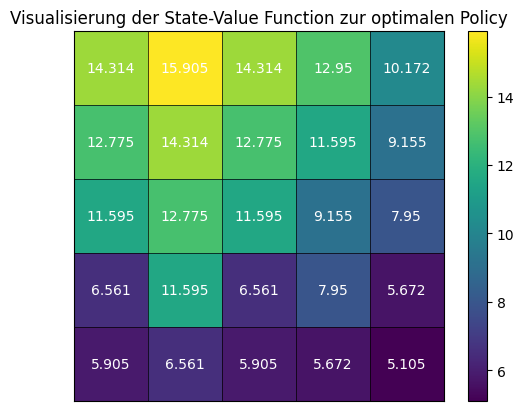

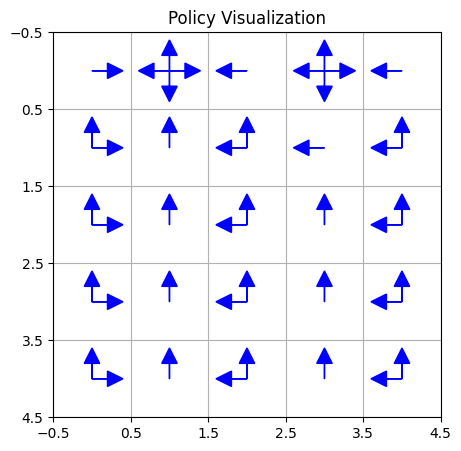

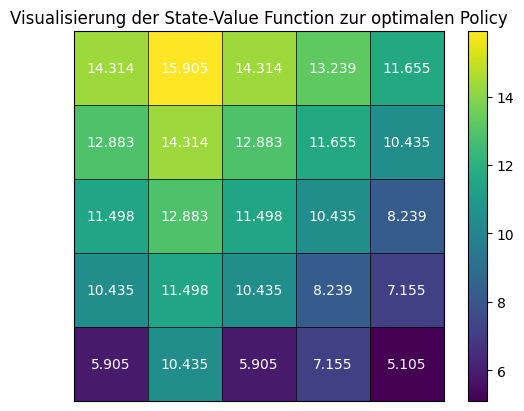

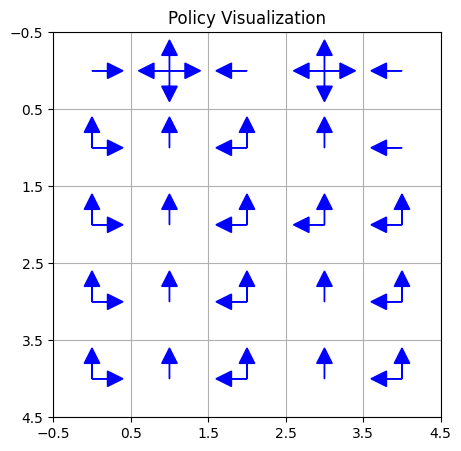

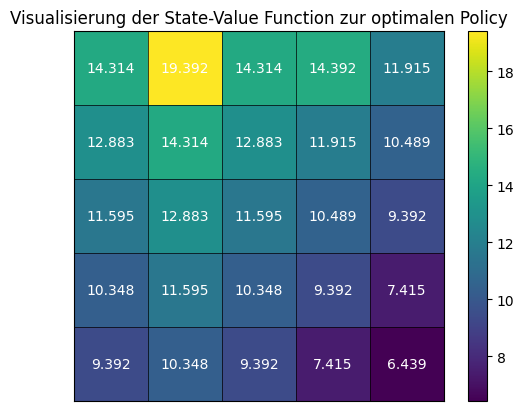

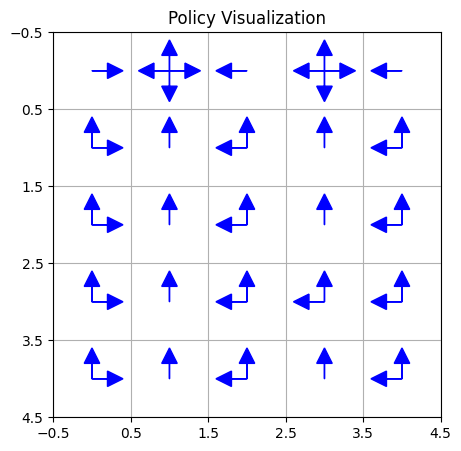

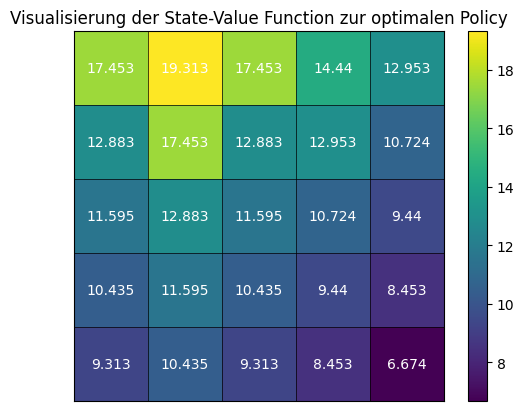

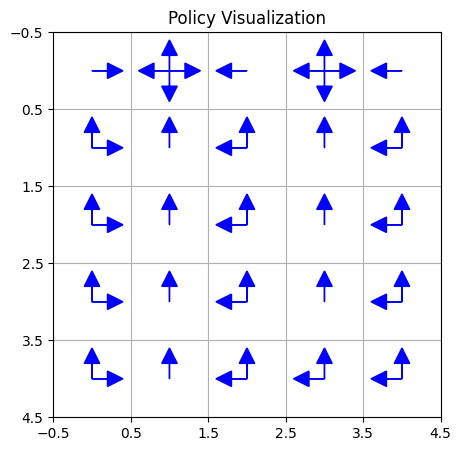

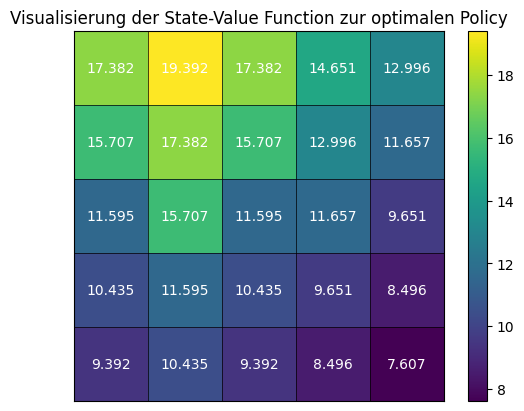

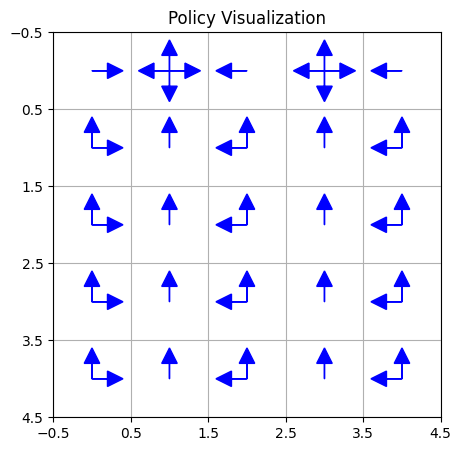

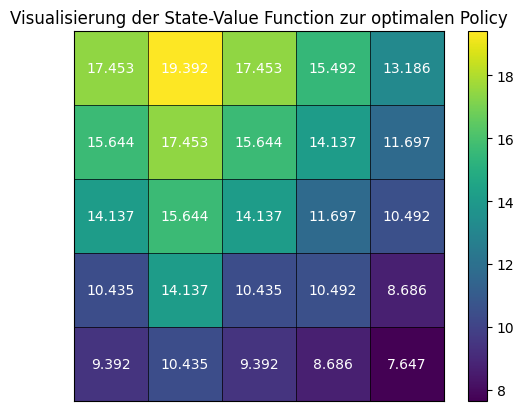

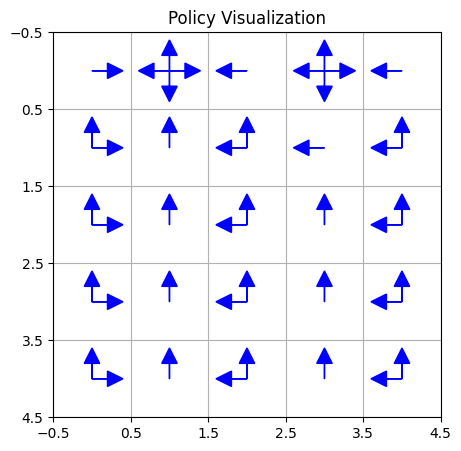

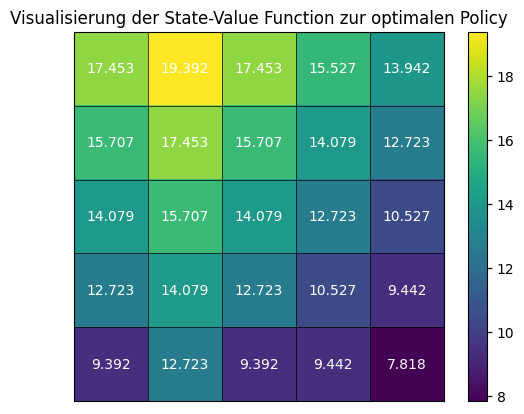

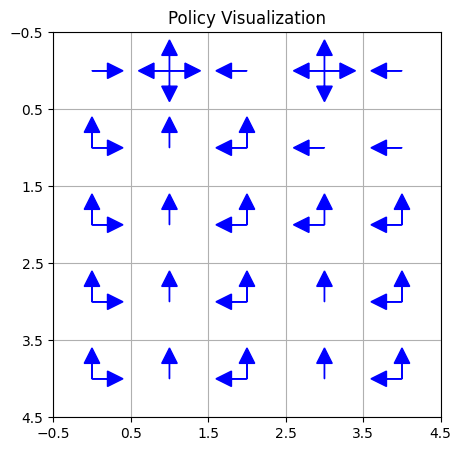

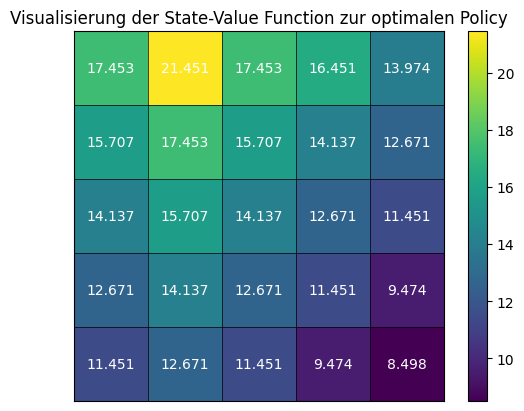

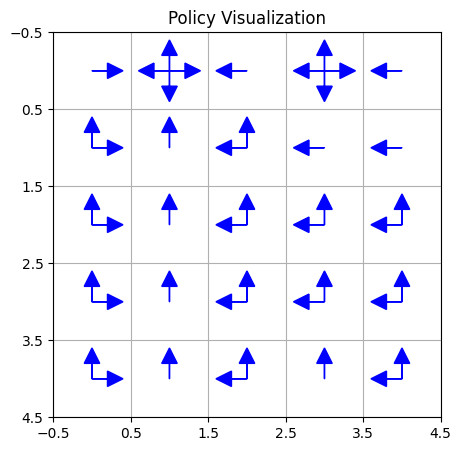

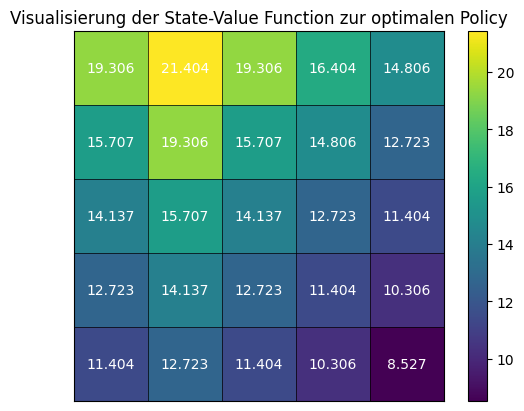

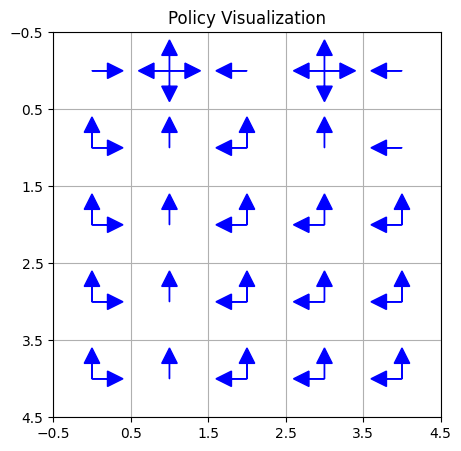

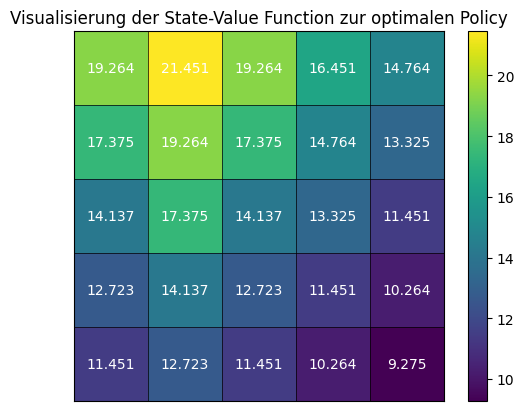

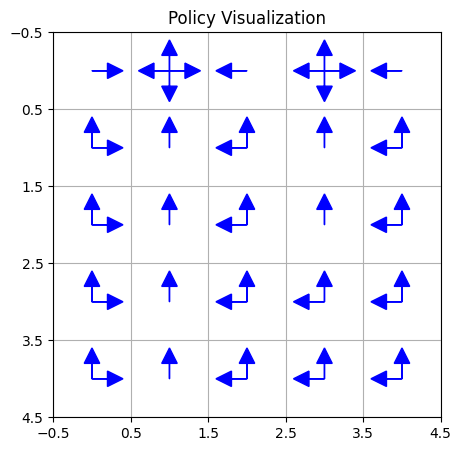

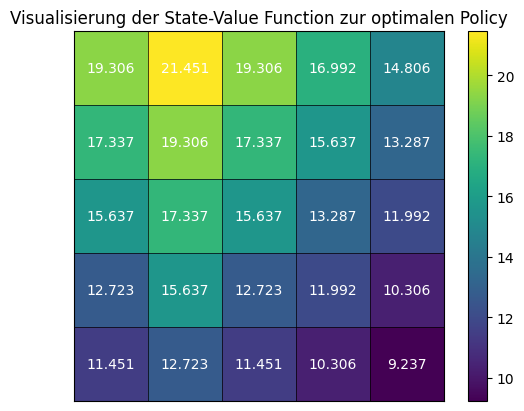

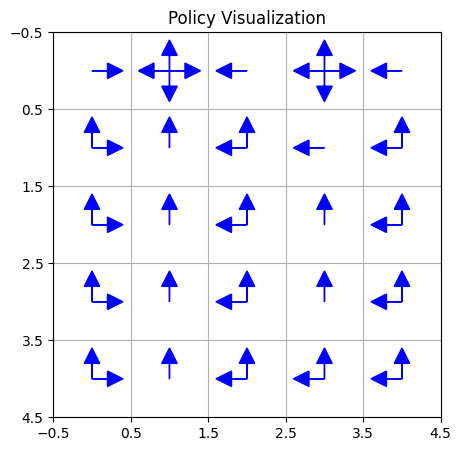

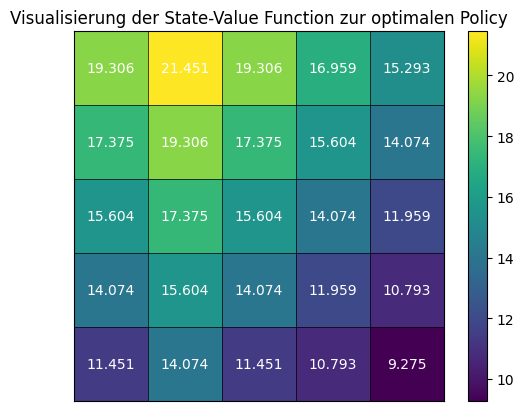

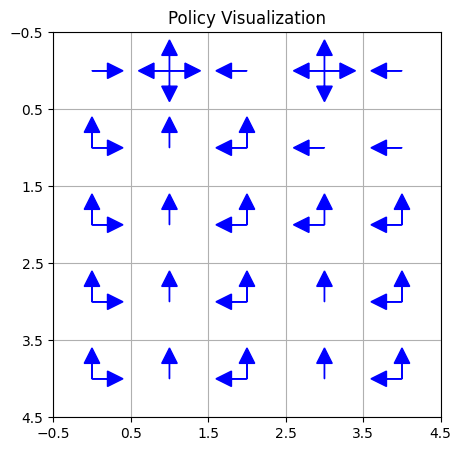

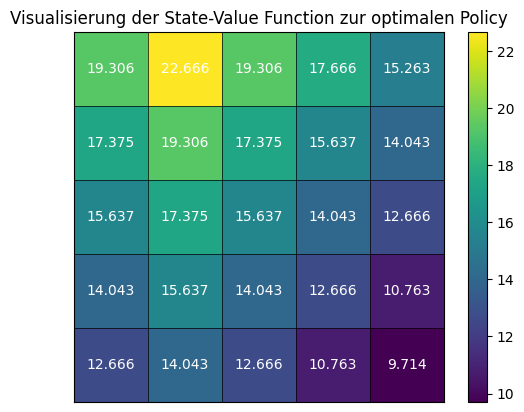

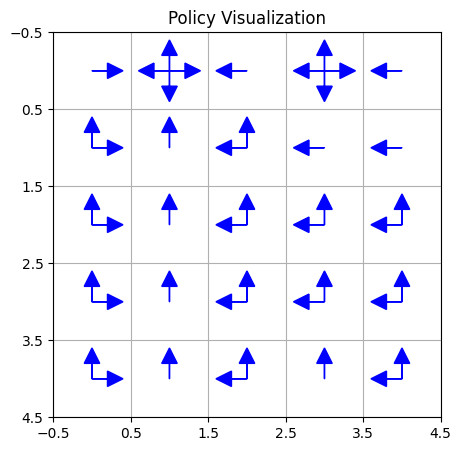

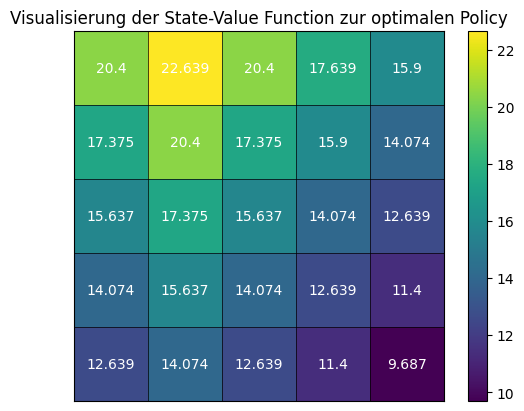

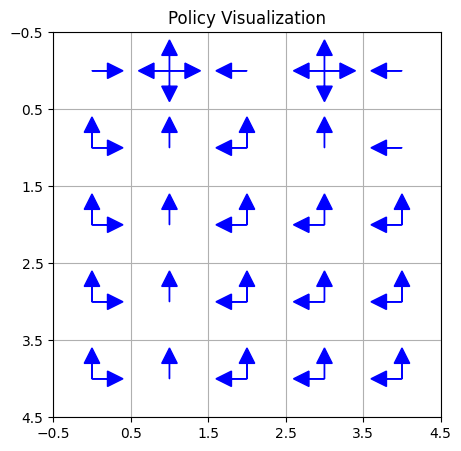

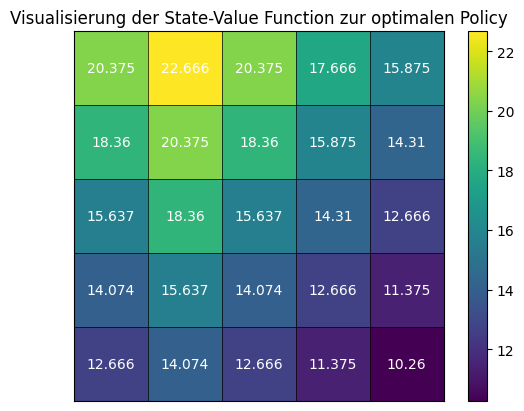

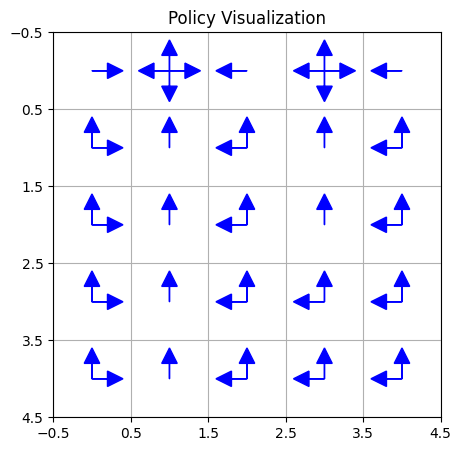

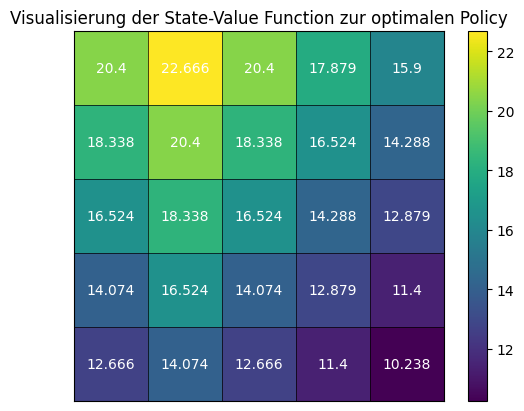

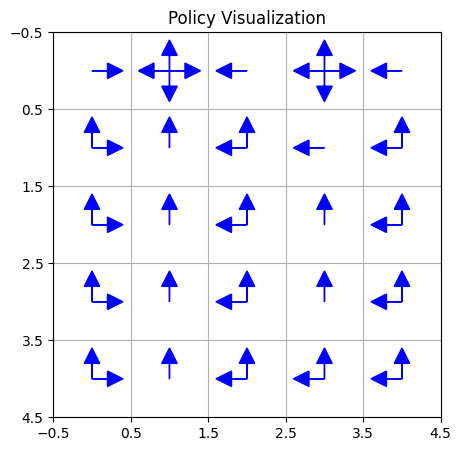

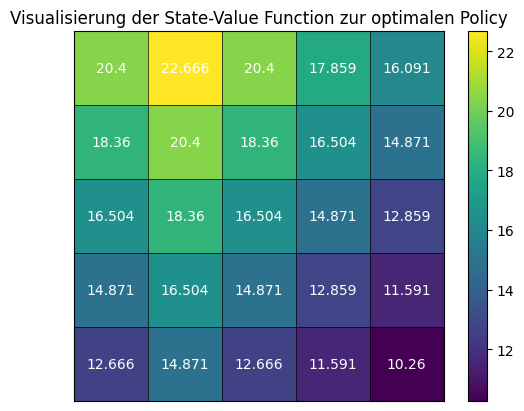

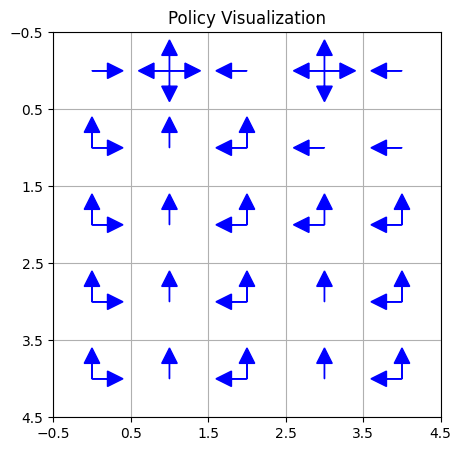

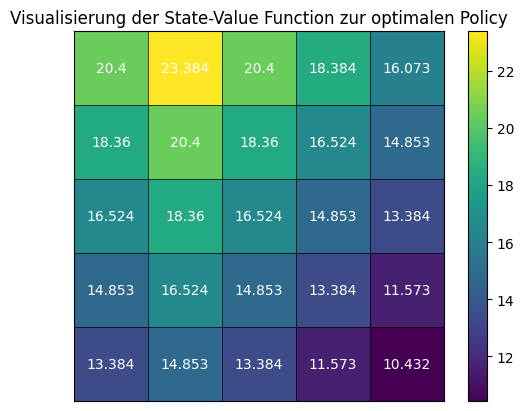

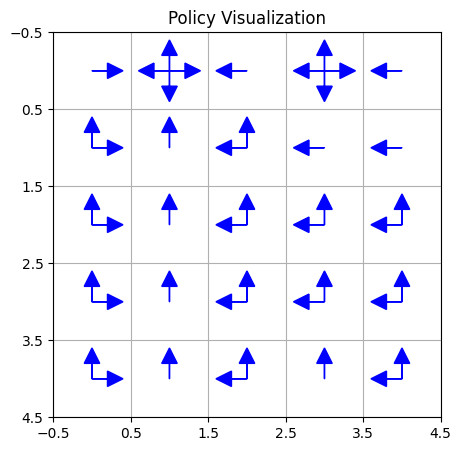

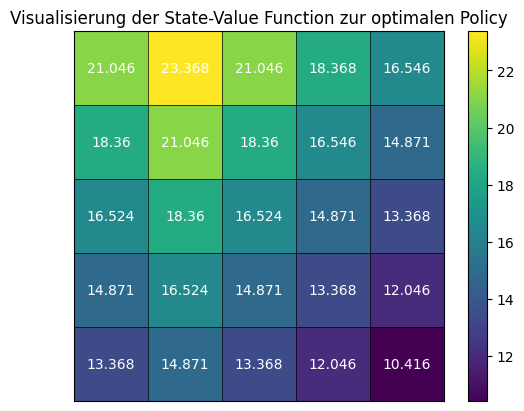

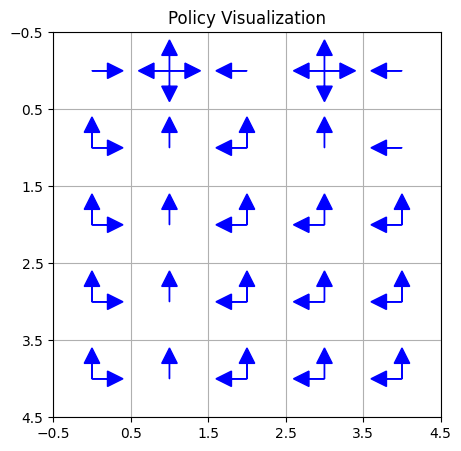

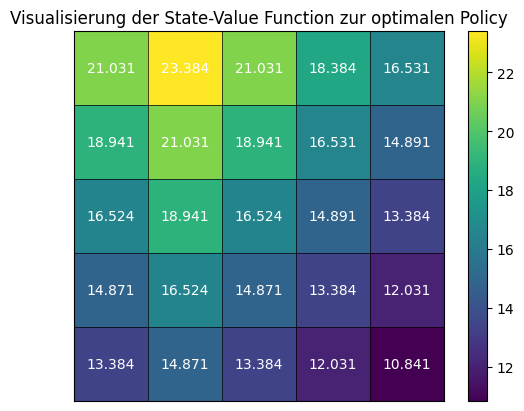

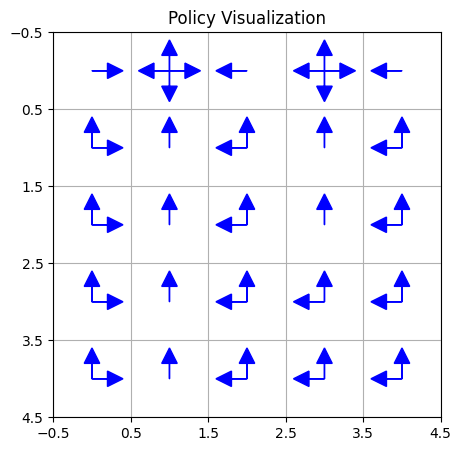

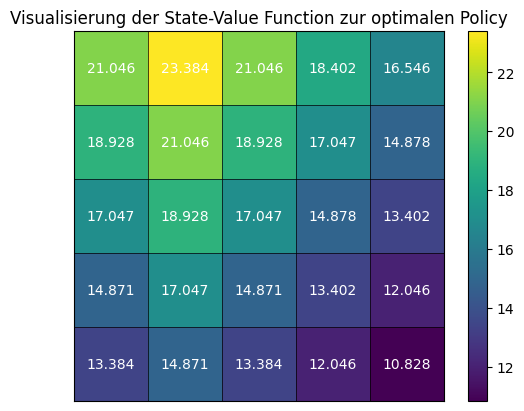

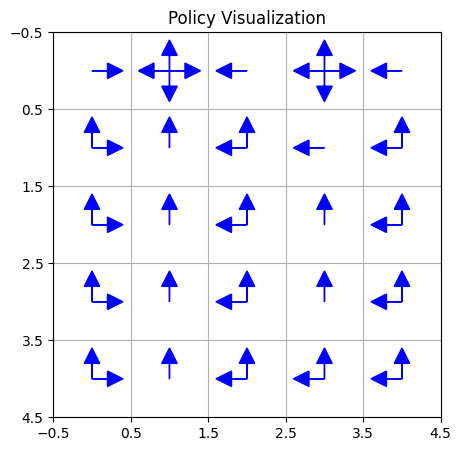

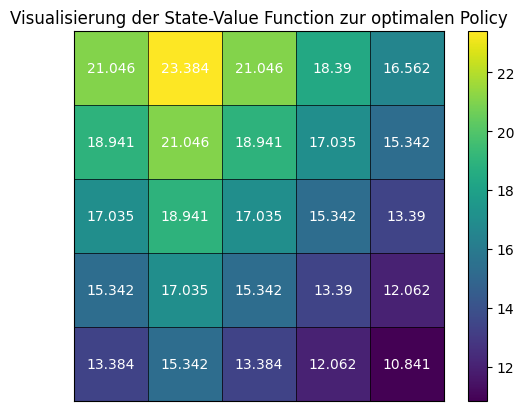

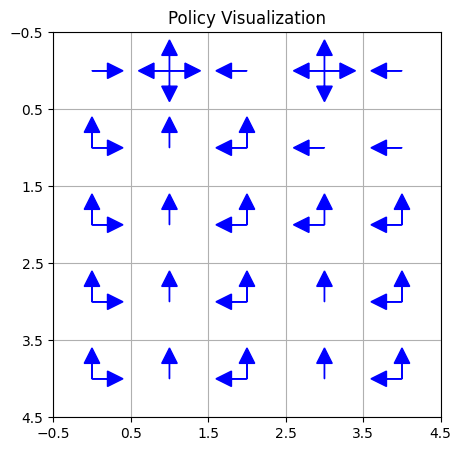

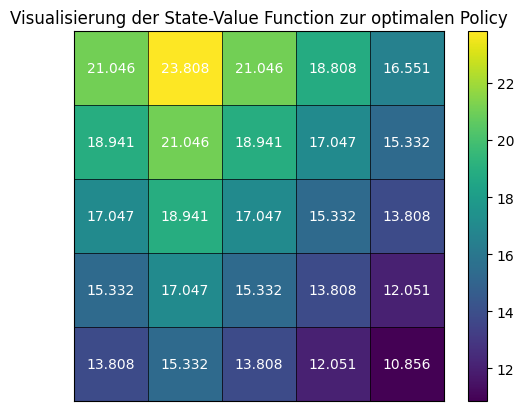

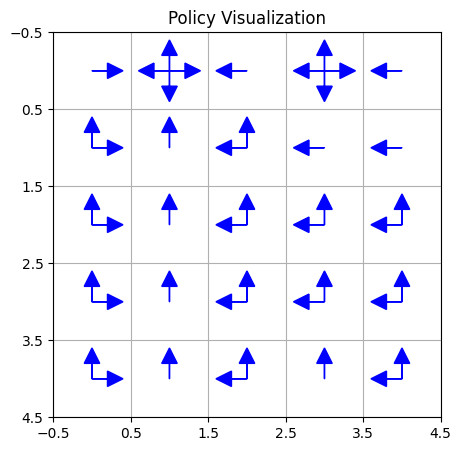

terminated because of max iterations


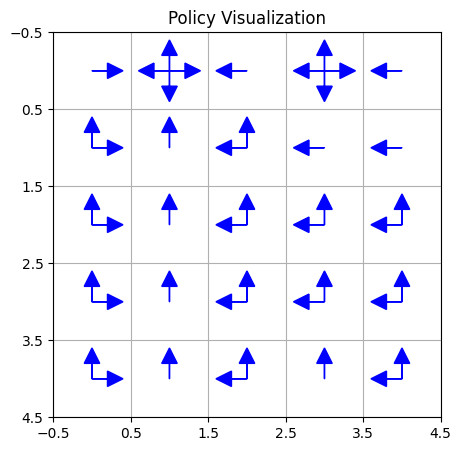

In [11]:
current_policy, current_state_value_end = policy_improvement_value_iteration(max_policy_improvement_iterations)

visualize_policy(current_policy)

After a lot of plots for part b), we now start with c). We implement the policy improvement using the action value function instead of the state value function. We did not find a formula for this in the script, so we came up with a (reasonable) approach by ourselves. 

In [12]:
def policy_improvement_action_value_function(max_policy_improvement_iterations, max_iterations_action, epsilon_action): 
    actions = ["N", "S", "W", "E"]
    num_actions = len(actions)
    grid_size = 5
    gamma = 0.9
    
    policy = 1/num_actions * np.ones((grid_size, grid_size, num_actions))
    action_value, _ = compute_action_val_function(max_iterations_action, epsilon_action, policy)

    for i in range(max_policy_improvement_iterations): 
        current_policy = np.zeros((grid_size, grid_size, num_actions))

        #Choose new policy as argmax 
        for j in range(grid_size): 
            for k in range(grid_size): 
                values_of_strange_q = np.zeros(num_actions)
                for l in range(num_actions): 
                    values_of_strange_q[l] = action_value[-1, j, k, l]

                values_of_strange_q = np.round(values_of_strange_q, 4)
                best_actions = np.where(values_of_strange_q == np.max(values_of_strange_q))[0] # i.e. argmax but cooler
                current_policy[j,k, best_actions] = 1/len(best_actions)
        
        current_action_value, _ = compute_action_val_function(max_iterations_action, epsilon_action, current_policy)
        
        if np.all(current_policy == policy): 
            print("terminated because of no policy improvement")
            return current_policy, current_action_value

        policy = current_policy
        action_value = current_action_value
        
    print("terminated because of max iterations")
    return current_policy, current_action_value 

terminated because of no policy improvement


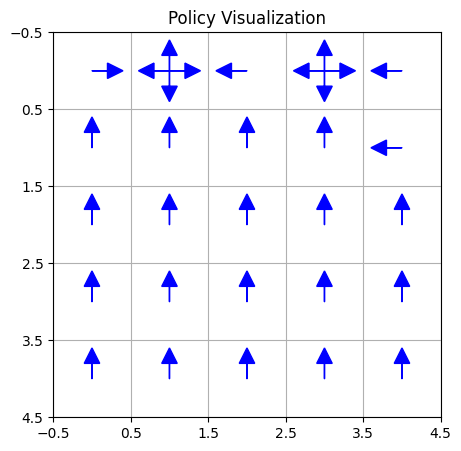

In [13]:
policy_action_value_function, action_value_last = policy_improvement_action_value_function(max_policy_improvement_iterations, max_iterations_action, epsilon_action)
visualize_policy(policy_action_value_function)


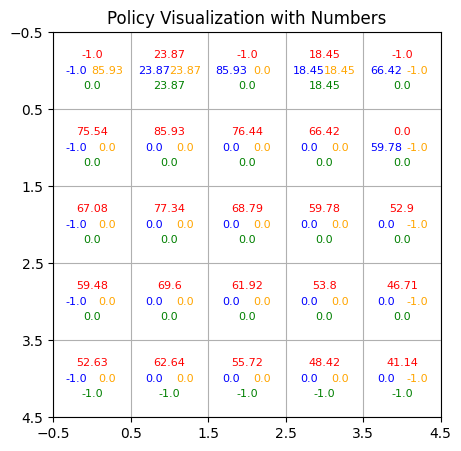

In [14]:
def visualize_policy_with_numbers(policy):
    policy = np.round(policy, 2)
    n_rows, n_cols, n_dirs = policy.shape

    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True)

    for i in range(n_rows):
        for j in range(n_cols):
            ax.text(j, i - 0.2, f"{policy[i, j, 0]}", ha='center', va='center', fontsize=8, color="red")  # North
            ax.text(j, i + 0.2, f"{policy[i, j, 1]}", ha='center', va='center', fontsize=8, color="green")  # South
            ax.text(j - 0.2, i, f"{policy[i, j, 2]}", ha='center', va='center', fontsize=8, color="blue")  # West
            ax.text(j + 0.2, i, f"{policy[i, j, 3]}", ha='center', va='center', fontsize=8, color="orange")  # East

    # Reverse the y-axis to align with matrix indexing
    ax.invert_yaxis()
    plt.title("Policy Visualization with Numbers")
    plt.show()

# Beispiel für ein 5x5x4 Array
visualize_policy_with_numbers(action_value_last[-1, :, :, :])
